In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Pegando as cotações do período necessário para a base fictícia na API

In [ ]:
start_date = '12-29-2023'
end_date = '05-15-2025'
url = (
    "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/"
    "CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?"
    f"@dataInicial='{start_date}'&@dataFinalCotacao='{end_date}'&"
    "$format=json&$select=cotacaoCompra,cotacaoVenda,dataHoraCotacao"
)

response = requests.get(url, timeout=15)
response.raise_for_status()
data = response.json()["value"]
df_quotations = pd.DataFrame(data)

df_quotations['dataHoraCotacao'] = pd.to_datetime(df_quotations['dataHoraCotacao']).dt.date
df_quotations = df_quotations.rename(columns={
    'cotacaoCompra': 'compra',
    'cotacaoVenda': 'venda',
    'dataHoraCotacao': 'data'
})
df_quotations['data'] = pd.to_datetime(df_quotations['data'])

# Preenchendo com datas faltantes

In [ ]:

all_dates = pd.date_range(start='2023-12-29', end='2025-05-15')
df_all = pd.DataFrame({'data': all_dates})

df_complete = pd.merge(df_all, df_quotations, on='data', how='left')

df_complete[['compra', 'venda']] = df_complete[['compra', 'venda']].ffill()

df_complete.reset_index(drop=True, inplace=True)

,data,compra,venda
0,2023-12-29,4.8407,4.8413
1,2023-12-30,4.8407,4.8413
2,2023-12-31,4.8407,4.8413
3,2024-01-01,4.8407,4.8413
4,2024-01-02,4.8910,4.8916
...,...,...,...
500,2025-05-11,5.6505,5.6511
501,2025-05-12,5.6816,5.6822
502,2025-05-13,5.6256,5.6262
503,2025-05-14,5.6094,5.6100


## Transformando base fictícia em dataframe

In [14]:
df_contas_ficticias = pd.read_csv('base_ficticia.csv', sep=';')
df_contas_ficticias.columns = [col.strip() for col in df_contas_ficticias.columns]
col_valor = next(col for col in df_contas_ficticias.columns if 'USD' in col)

df_contas_ficticias[col_valor] = (
    df_contas_ficticias[col_valor]
    .replace({'\$': '', '\.': '', ',': '.'}, regex=True)
    .astype(float)
)

df_contas_ficticias['Data'] = pd.to_datetime(df_contas_ficticias['Data'], format='%Y-%m-%d')
df_contas_ficticias.head()


,Conta,Data,Posição (USD)
0,ACC0001,2024-01-01,1099342.83
1,ACC0001,2024-01-02,1099442.83
2,ACC0001,2024-01-03,1099542.83
3,ACC0001,2024-01-04,1099642.83
4,ACC0001,2024-01-05,1099742.83


# Calculo da receita diária

In [18]:
df_contas_ficticias['Data'] = pd.to_datetime(df_contas_ficticias['Data'])

df_resultado = pd.merge(
    df_contas_ficticias,
    df_complete[['data', 'venda']],
    left_on='Data',
    right_on='data',
    how='left'
)

df_resultado = df_resultado.rename(columns={'venda': 'Cotação Dólar'})

df_resultado['Taxa Anual'] = 0.005 
df_resultado['Accrual diário taxa'] = 0.00137
df_resultado['Posição BRL'] = (df_resultado['Posição (USD)'] * df_resultado['Cotação Dólar']).round(2)
df_resultado['Receita ao dia'] = (df_resultado['Accrual diário taxa'] * df_resultado['Posição BRL'] / 100).round(2)

df_resultado = df_resultado.drop(columns=['data'])
df_resultado.head()

,Conta,Data,Posição (USD),Cotação Dólar,Taxa Anual,Accrual diário taxa,Posição BRL,Receita ao dia
0,ACC0001,2024-01-01,1099342.83,4.8413,0.005,0.00137,5322248.44,72.91
1,ACC0001,2024-01-02,1099442.83,4.8916,0.005,0.00137,5378034.55,73.68
2,ACC0001,2024-01-03,1099542.83,4.9212,0.005,0.00137,5411070.17,74.13
3,ACC0001,2024-01-04,1099642.83,4.9188,0.005,0.00137,5408923.15,74.10
4,ACC0001,2024-01-05,1099742.83,4.8899,0.005,0.00137,5377632.46,73.67


## Cálculo da receita mensal

In [23]:
import matplotlib.pyplot as plt

df_resultado['Ano-Mês'] = df_resultado['Data'].dt.to_period('M').astype(str)
receita_mensal = df_resultado.groupby('Ano-Mês')['Receita ao dia'].sum().reset_index()

receita_mensal


,Ano-Mês,Receita ao dia
0,2024-01,101983.04
1,2024-02,120056.95
2,2024-03,125364.17
3,2024-04,97377.31
4,2024-05,97288.81
5,2024-06,99123.76
6,2024-07,112665.49
7,2024-08,190006.66
8,2024-09,187358.79
9,2024-10,173637.55


## Plotando gráfico de receita mensal

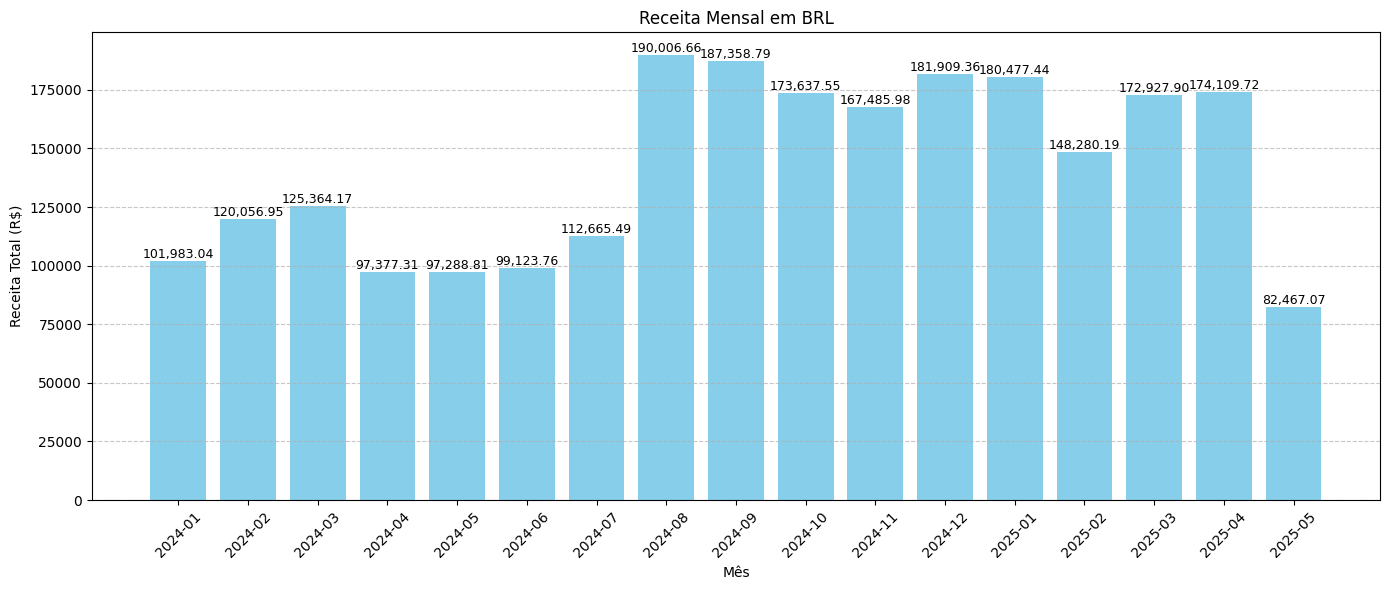

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
bars = plt.bar(receita_mensal['Ano-Mês'], receita_mensal['Receita ao dia'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:,.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.title('Receita Mensal em BRL')
plt.xlabel('Mês')
plt.ylabel('Receita Total (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('grafico_receita_mensal.png', dpi=300)
plt.show()


